In [1]:
%matplotlib inline

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from scipy import stats

In [3]:
sns.set_style('ticks')
sns.set_context('talk')
import warnings; warnings.simplefilter('ignore')

In [4]:
data_dir = '/home/julia/data/ict/'

### Load one session

In [26]:
mouse = 'UUU'
df = pd.read_pickle(data_dir+'mice/{}.pkl'.format(mouse))

day=0
raw_signal = df[(df['day']==day)]['gpmt']
raw_reference = df[(df['day']==day)]['rpmt']

### Loop over trials

In [29]:
remove = 1000

all_signal = np.empty(0)
all_reference = np.empty(0)

for trial in range(len(raw_signal)):
    smooth_signal = gaussian_filter1d(raw_signal.iloc[trial], sigma=100, axis=0, output=np.float64)
    smooth_reference = gaussian_filter1d(raw_reference.iloc[trial], sigma=100, axis=0, output=np.float64)
    
    F0_signal = np.mean(smooth_signal[4000:5000])
    F0_reference = np.mean(smooth_reference[4000:5000])
    delta_signal = (smooth_signal - F0_signal) / F0_signal
    delta_reference = (smooth_reference - F0_reference) / F0_reference
    
    all_signal = np.append(all_signal, delta_signal[remove:-remove])
    all_reference = np.append(all_reference, delta_reference[remove:-remove])

## Fit two Gaussians to all values of session

In [99]:
gmm = GaussianMixture(n_components=2, covariance_type='spherical')
fit = gmm.fit(all_reference.reshape(-1,1))
predict = gmm.predict(all_reference.reshape(-1,1))

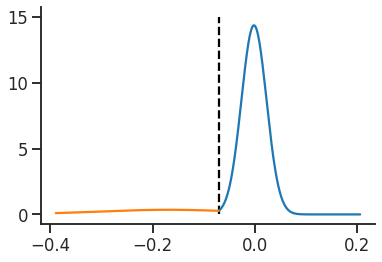

In [156]:
x = np.linspace(all_reference.min(), all_reference.max(), 1000)
y0 = fit.weights_[0] * stats.norm.pdf(x, fit.means_[0], np.sqrt(fit.covariances_[0]))
y1 = fit.weights_[1] * stats.norm.pdf(x, fit.means_[1], np.sqrt(fit.covariances_[1]))

lim_idx = np.where(np.abs(y0-y1)<0.01)[0][0]
lim = x[lim_idx]

plt.plot(x[lim_idx:],y0[lim_idx:])
plt.plot(x[:lim_idx],y1[:lim_idx])
plt.vlines(lim, 0,15, linestyle='--')

sns.despine()

## Fit signals in lower Gaussian using linear regression

In [175]:
fit_reference = all_reference[all_reference<lim]
fit_signal = all_signal[all_reference<lim]
non_fit_signal = all_signal[all_reference>=lim]
non_fit_reference = all_reference[all_reference>=lim]

In [205]:
lin = LinearRegression()
model = lin.fit(fit_reference.reshape(-1,1), fit_signal.reshape(-1,1))
reference_fitted = lin.predict(all_reference.reshape(-1,1))

In [199]:
idx_a=np.arange(0,fit_signal.shape[0],100)
idx_b=np.arange(0,non_fit_signal.shape[0],100)

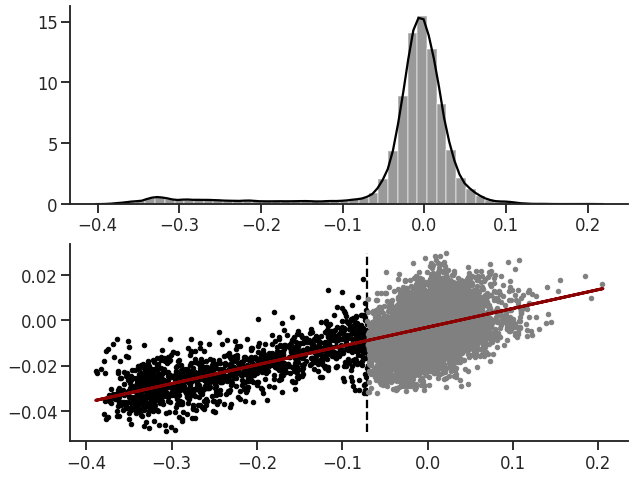

In [204]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
sns.despine(ax=ax1, left=True, bottom=True)
sns.distplot(all_reference, color='black', hist=True, ax=ax1)

ax2 = fig.add_subplot(212)
ax2.plot(fit_reference[idx_a],fit_signal[idx_a],color='black', marker='.',linewidth=0)
ax2.plot(non_fit_reference[idx_b],non_fit_signal[idx_b],color='grey', marker='.', linewidth=0)
ax2.plot(all_reference,reference_fitted, color='darkred',linewidth=3)
ax2.vlines(lim, all_signal.min(), all_signal.max(), linestyle='--', color='black')
sns.despine()

## Clean up every trial by using coefficients from this fit

In [215]:
a = model.intercept_[0]
b = model.coef_[0,0]

In [220]:
trial = 20
smooth_signal = gaussian_filter1d(raw_signal.iloc[trial], sigma=100, axis=0, output=np.float64)
smooth_reference = gaussian_filter1d(raw_reference.iloc[trial], sigma=100, axis=0, output=np.float64)

F0_signal = np.mean(smooth_signal[4000:5000])
F0_reference = np.mean(smooth_reference[4000:5000])
delta_signal = (smooth_signal - F0_signal) / F0_signal
delta_reference = (smooth_reference - F0_reference) / F0_reference

In [221]:
corr_signal = delta_signal - a*delta_reference - b

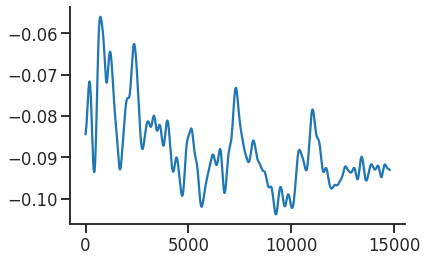

In [224]:
remove=1000
plt.plot(corr_signal[remove:-remove])
sns.despine()

### Standardize

In [228]:
z_signal = (corr_signal[remove:-remove] - np.median(corr_signal[remove:-remove])) / np.std(corr_signal[remove:-remove])

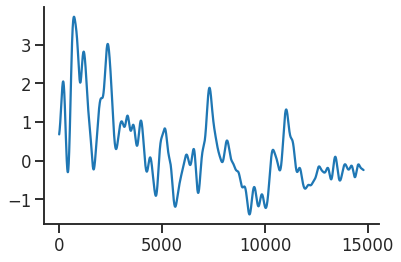

In [229]:
plt.plot(z_signal)
sns.despine()